# 0. Stacking Ensemble: Overview

Stacked ensemble learning is a layered-structure machine learning approach that combines the predictive competency of diverse base learning algorithms to attain higher prediction accuracy compared to the individual weak learners [1]. Stacking is an ensemble learning technique to combine multiple classification models via a meta-classifier. It uses a meta-learning algorithm to learn how to best combine the predictions from two or more base machine learning algorithms. 

![SEL](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier_files/stackingclassification_overview.png)

The **benefit** of stacking is that it can harness the capabilities of a range of well-performing models on a classification or regression task and make predictions that have better performance than any single model in the ensemble.

***Eventually, this notebook concludes that the Stacking ensemble learning approach can be a substantial paradigm in machine learning studies to improve models accuracy and reduce the error rate.***

Now, Let's get our hands dirty by exploring and implementing a Stacking ensemble learning model.

# 1. Dataset Description

The Breast Cancer datasets is available UCI machine learning repository maintained by the University of California, Irvine. The dataset contains 569 samples of malignant and benign tumor cells.

The first two columns in the dataset store the unique ID numbers of the samples and the corresponding diagnosis (M=malignant, B=benign), respectively. The columns 3-32 contain 30 real-value features that have been computed from digitized images of the cell nuclei, which can be used to build a model to predict whether a tumor is benign or malignant.

* 1= Malignant (Cancerous) - Present (M)
* 0= Benign (Not Cancerous) -Absent (B)

The dataset can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29 

I have cleaned the data beforehand and then used it accordingly. Perhaps, you can check [THIS](https://www.kaggle.com/pankajbhowmik/breast-cancer-analysis-prediction/notebook) notebook for further interest.

# 2. Load libraries and read the data

In [1]:
# Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
from numpy import mean
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
#from mlxtend.classifier import StackingCVClassifier
import warnings
warnings.simplefilter(action ="ignore")

In [2]:
data = pd.read_csv('../input/breast-cancer-dataset-clean-data/data.csv')
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})
X = data.loc[:, data.columns != 'diagnosis']
y = data['diagnosis']

# EDA

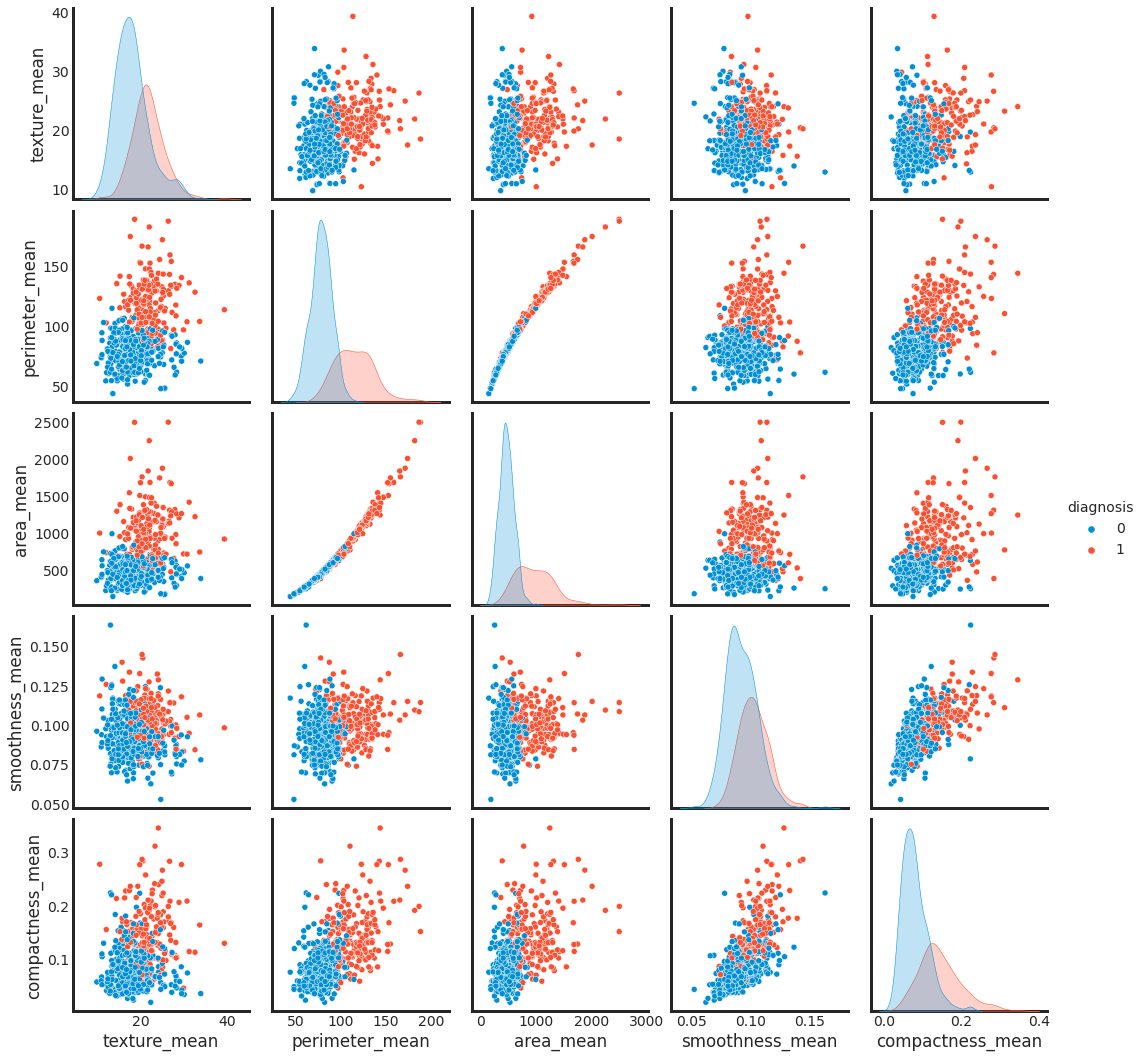

In [5]:
#Visualizing Multidimensional Relationships
plt.style.use('fivethirtyeight')
sns.set_style("white")
sns.pairplot(data[[data.columns[30], data.columns[1],data.columns[2],data.columns[3],
                     data.columns[4], data.columns[5]]], hue = 'diagnosis' , size=3)

# 3. List of Individual Algorithms

Here, we choose four tree-based algorithms for this notebook.

1. Random Forest Classifier
1. Decision Tree Classifier
1. Extra Trees Classifier and
1. XGBoost Classifier

Each algorithm will be evaluated using the known optimal hyperparameters. *[**You can further optimize the parameters of models with Grid search or Randomize Search or so on**]*. The function *get_models()* below creates the models we wish to evaluate.

Each model will be evaluated using k-fold cross-validation.
The *evaluate_model()* function below takes a model instance and returns a list of scores from 10-fold cross-validation.

In [7]:
def get_models():
    models = dict()
    models['Random Forest'] = RandomForestClassifier(criterion='entropy', n_estimators=250, min_samples_leaf=1, min_samples_split=2, random_state=42)
    models['Decision Tree'] = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='log2', min_samples_split=3, random_state=42)
    models['Extra Trees'] = ExtraTreesClassifier(criterion='gini', n_estimators=350, max_depth=15, min_samples_split=2, random_state=42)        
    models['xb'] = xgb.XGBClassifier(learning_rate = 0.01, max_depth = 10, min_child_weight = 3, subsample = 0.5, colsample_bytree = 0.7, n_estimators = 100)
    return models

def evaluate_model(model, X, y):
    kfold = model_selection.KFold(n_splits=10, random_state=42)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=kfold, n_jobs=-1, error_score='raise')
    #scores = cross_val_score(model, X, y, scoring='precision', cv=kfold, n_jobs=-1, error_score='raise')
    return scores

In [8]:
print('Accuracy Score of individual models in Cross Validation:')
#get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('Accuracy Score of %s = %0.2f' % (name, mean(scores)*100))

Accuracy Score of individual models in Cross Validation:
Accuracy Score of Random Forest = 95.96
Accuracy Score of Decision Tree = 92.79
Accuracy Score of Extra Trees = 96.31
Accuracy Score of xb = 94.38


# 4. Implement Stacking Ensemble Model

The scikit-learn Python machine learning library provides an implementation of Stacking ensemble for machine learning.

In [11]:
kfold = model_selection.KFold(n_splits=10, random_state=42)
estimators = [
    ('rf', RandomForestClassifier(criterion='entropy', n_estimators=250, min_samples_leaf=1, min_samples_split=2, random_state=42)),
    ('dt', DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='log2', min_samples_split=3, random_state=42)),
    ('et', ExtraTreesClassifier(criterion='gini', n_estimators=350, max_depth=15, min_samples_split=2, random_state=42)),
    ('xb', xgb.XGBClassifier(learning_rate = 0.01, max_depth = 10, min_child_weight = 3, subsample = 0.5, colsample_bytree = 0.7, n_estimators = 100))

]
Xg = xgb.XGBClassifier(learning_rate = 0.01, max_depth = 10, min_child_weight = 3, subsample = 0.5, colsample_bytree = 0.7, n_estimators = 100)
ensemble = StackingClassifier(estimators=estimators, final_estimator=Xg, cv = kfold)
#clf= StackingCVClassifier(classifiers=[rF, dT, eT], meta_classifier= rF, random_state=42, cv=kfold)
en_acc = cross_val_score(ensemble, X, y, scoring='accuracy', cv=kfold, n_jobs=-1, error_score='raise')
print('Accuracy of Ensemble Model = %.4f' % (mean(en_acc)*100))
#en_f1 = cross_val_score(ensemble, X, y, scoring='f1_macro', cv=kfold, n_jobs=-1, error_score='raise')
#print('F1-score of Ensemble Model = %.3f' % (mean(en_f1)))


[14:29:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:29:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:29:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:29:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old b

**Cross Validation Accuracy Comparison**

* Random Forest Classifier = 95.96%
* Decision Tree Classifier = 92.79%
* Extra Trees Classifier = 96.31%
* XGBoost Classifier = 94.38%
* **Ensemble Learning Model = 96.66%**

Although the individual classifier models showed reasonable outcomes, the Stacking ensemble learning approach has boosted the performance of the final model. The Stacked ensemble model outweighed the individual models, not significantly though comaparing with Extra Trees Classifier.

 ***Feel free to try other machine learning algorithms and switch the meta learner as well, to see whether the outcome changes.**

**Reference**

[1] Pankaj Bhowmik et al. "Cardiotocography Data Analysis to Predict Fetal Health Risks with Tree-Based Ensemble Learning", International Journal of Information Technology and Computer Science(IJITCS), Vol.13, No.5, pp.30-40, 2021. DOI: 10.5815/ijitcs.2021.05.03 link: http://www.mecs-press.org/ijitcs/ijitcs-v13-n5/v13n5-3.html 

[2] Susan Yuhou Xia, “Using a Stacking Model Ensemble Approach to Predict Rare Events,” Conference Talks, SciPy 2019, 18th annual Scientific Computing with Python Conference, in Austin, Texas, USA. [Online]. Available: youtube.com/watch?v=6oD5K0x1k7c&t=551s